# Setup

 Import standard modules

In [1]:
import pandas as pd
import numpy as np
import sys
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.integrate import solve_ivp
from matplotlib import pyplot as plt
import time

Set root directory

In [2]:
from pyprojroot import here
root = here()
sys.path.append(str(root))
wdir = root / "data" / "interim" / "tides"

Import project modules

In [3]:
from tidal_flat_0d import models
from tidal_flat_0d import features
from tidal_flat_0d import visualization as viz

# Run Model

In [4]:
# Load Tides
dt = 30
#tide_name = "tides-debug-1s.feather"
tide_name = 'tides-1yr-1s.feather'
tides = features.load_tide(wdir, tide_name)
tides = tides.iloc[0:-1:dt]
timestep = pd.Timedelta(tides.index.freq).total_seconds()

# Set grain parameters and settling velocity
grain_dia = 0.000035  # grain diameter (m)
grain_den = 2650
settle_rate = models.stokes_settling(grain_dia=grain_dia, grain_den=grain_den)

# Set basic model parameters
bound_conc = 0.8
bulk_dens = 1100
min_depth = 0.001
init_elev = 0
init_conc = 0
years = 5
slr = 0.005

In [5]:
result, ts = models.run_model(tides_ts=tides, settle_rate=settle_rate, bulk_dens=bulk_dens, bound_conc=bound_conc, init_elev=init_elev, years=years, slr=slr)

Total accumulation: 1.206618 m
Final Elevation: 1.2066 m


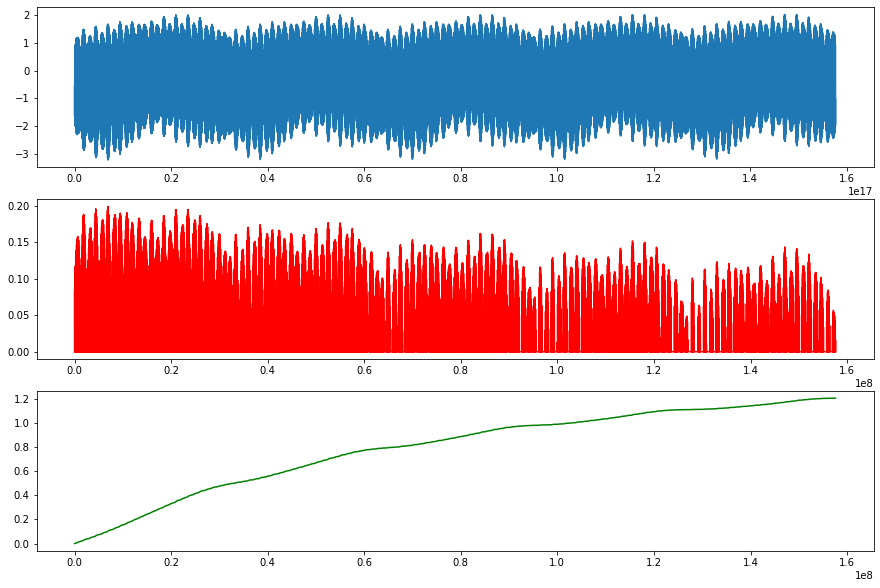

In [23]:
fig, axs = plt.subplots(3, 1)
fig.set_figheight(10)
fig.set_figwidth(15)
axs[0].plot(ts)
axs[1].plot(result.concentration, color='r')
axs[2].plot(result.elevation, color='g')